# Image Matting
## Description:
Image Matting is a project thats inspired through Apple's Photo Subject copy feature in there iPhones. This is a Image segmentation model built on top of a U-Net architecture,
the primary purpose of the model is to predict the main subject in the image segment it and using the segmented image given by the model, the original image is compared to segmented image and the subject in the original image is removed.

This model is trianed with around 950 images for 300 epoch with a batch of 32

## Input shape:
(128,128,3)

## Training data:
Data for the model where fetched from the internet and was segmented in GIMP software before sending it for training.
To train the model with more data add images on the respective images directory and then run datapreprocessing.ipynb file to rename and fetch all writable images
After re-writing the images and transfer all the images to a photo editing software and segmented it like shown in the video uploaded in the repository

## Frameworks and Languages used:
1. Tensorflow
2. Keras
3. Numpy
4. Scikit-learn
5. Matplotlib


### Modules Required for training and data processing

In [ ]:
#Modules
import tensorflow as tf
import os
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import random as rd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## U-Net

## Convolution function

In [ ]:
#convolution function
def convolution(input,filters,kernel):
  conv=tf.keras.layers.Conv2D(filters=filters,kernel_size=(kernel,kernel),padding="same")(input)
  activation=tf.keras.layers.Activation(activation="relu")(conv)
  return activation

## Encoder Block

In [ ]:
#Encoder function to build encoder regions
def encoder_block(input,filters,kernel):
  conv=convolution(input=input,filters=filters,kernel=kernel)
  maxpool=tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
  dropout=tf.keras.layers.Dropout(rate=0.3)(maxpool)
  return conv,dropout

## Bottleneck Layer

In [ ]:
#Bottleneck function to build bottleneck function
def bottleneck_block(input):
  conv=convolution(input=input,filters=1024,kernel=3)
  return conv

## Decoder Block

In [ ]:
#Deocder function to build decoder regions
def decoder_block(input,conv,filters,kernel):
  convT=tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=(kernel,kernel),strides=(2,2),padding="same")(input)
  concat=tf.keras.layers.Concatenate()([convT,conv])
  dropout=tf.keras.layers.Dropout(rate=0.3)(concat)
  conv=convolution(input=dropout,filters=filters,kernel=kernel)
  return conv

## Encoder block combined with filters

In [ ]:
#Encoder layers
def encoder(input):
  conv64,encoder64=encoder_block(input=input,filters=64,kernel=3)
  conv128,encoder128=encoder_block(input=encoder64,filters=128,kernel=3)
  conv256,encoder256=encoder_block(input=encoder128,filters=256,kernel=3)
  conv512,encode512=encoder_block(input=encoder256,filters=512,kernel=3)
  return encode512,(conv64,conv128,conv256,conv512)

## Decoder block combined with filters

In [ ]:
#Decoder layers
def decoder(input,convs):
  encode_conv64,encode_conv128,encode_conv256,encode_conv512=convs
  conv512=decoder_block(input=input,conv=encode_conv512,filters=512,kernel=3)
  conv256=decoder_block(input=conv512,conv=encode_conv256,filters=256,kernel=3)
  conv128=decoder_block(input=conv256,conv=encode_conv128,filters=128,kernel=3)
  conv64=decoder_block(input=conv128,conv=encode_conv64,filters=64,kernel=3)
  return conv64

## U-Net Combined

In [ ]:
#U-Net model with Encoder and Decoder
def unet(OUTPUT_CLASSES):
  input=tf.keras.Input(shape=(128,128,3,))
  encoder_output,convs=encoder(input=input)
  bottleneck=bottleneck_block(input=encoder_output)
  decoder_output=decoder(input=bottleneck,convs=convs)
  output=tf.keras.layers.Conv2D(filters=OUTPUT_CLASSES,kernel_size=(1,1),activation="softmax")(decoder_output)
  model=tf.keras.Model(inputs=input,outputs=output)
  return model

## Dice score: to know the variantions in true and predicted value

In [ ]:
#Dice score function
def dice_score(y_true,y_pred):
  dice_score_classes=[]
  smoothing=0.001
  for i in range(3):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    dice_score =  2 * ((intersection + smoothing) / (combined_area + smoothing))
    dice_score_classes.append(dice_score)

  return dice_score_classes

In [ ]:
#Number of classes (Always keep an extra class for Unknown features)
OUTPUT_CLASSES=3

In [ ]:
model=unet(OUTPUT_CLASSES=OUTPUT_CLASSES)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['activation[0][0]']          
 D)                                                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

## Function to fetch the images and mask for training

In [ ]:
#Function to fetch images from directory
def getimages(x_path,y_path):
  x=[]
  y=[]
  xcount=0
  ycount=0
  for filename in os.listdir(x_path):
    img=cv.imread(os.path.join(x_path,filename))
    if img is not None:
      img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
      img=cv.resize(img,(128,128))/255.
      x.append(img)
      xcount+=1
    img=cv.imread(os.path.join(y_path,filename),cv.IMREAD_GRAYSCALE)
    if img is not None:
      img=cv.resize(img,(128,128))
      y.append(img)
      ycount+=1
  print(xcount," Images written")
  print(ycount," Masks written")
  return x,y

In [ ]:
x,y=getimages("/content/drive/MyDrive/Imagematting/dataset/images","/content/drive/MyDrive/Imagematting/dataset/masks")

239  Images written
239  Masks written


## Data augmentation
1. Flipping
2. Rotating

In [ ]:
#Function to flip images
def flip_images(x,y):
  x_flip=[]
  y_flip=[]
  count=0
  flip_code=[-1,0,1]
  for ximg,ymask in zip(x,y):
    fliprand=flip_code[rd.randint(0,2)]
    img=cv.flip(ximg,fliprand)
    mask=cv.flip(ymask,fliprand)
    x_flip.append(img)
    y_flip.append(mask)
    count+=1
  print(count," Number of images written")
  return x_flip,y_flip

In [ ]:
x_flip,y_flip=flip_images(x,y)

239  Number of images written


In [ ]:
x=x+x_flip
y=y+y_flip

In [ ]:
#Function to rotate images
def rotate_images(x,y):
  x_rotate=[]
  y_rotate=[]
  count=0
  rotate_code=[cv.ROTATE_90_CLOCKWISE,cv.ROTATE_180,cv.ROTATE_90_COUNTERCLOCKWISE]
  for ximg,ymask in zip(x,y):
    rotaterand=rotate_code[rd.randint(0,2)]
    img=cv.rotate(ximg,rotaterand)
    mask=cv.rotate(ymask,rotaterand)
    x_rotate.append(img)
    y_rotate.append(mask)
    count+=1
  print(count," Number of images written")
  return x_rotate,y_rotate

In [ ]:
x_rotate,y_rotate=rotate_images(x,y)

478  Number of images written


In [ ]:
x=x+x_rotate
y=y+y_rotate

In [ ]:
print("Number of images: ",len(x))
print("Number of mask: ",len(y))

Number of images:  956
Number of mask:  956


In [ ]:
x=np.array(x)
y=np.array(y)

In [ ]:
#Converting all mask to grayscale
y=(y>0).astype(np.uint8)

In [ ]:
x.shape

(956, 128, 128, 3)

In [ ]:
y.shape

(956, 128, 128)

In [ ]:
randnum=rd.randint(0,100)

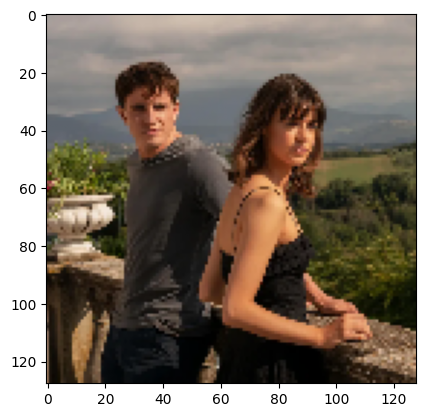

In [ ]:
plt.imshow(x[randnum])

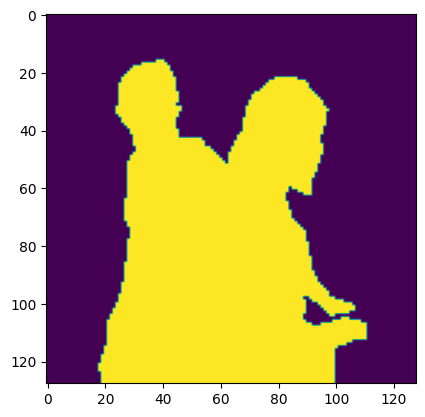

In [ ]:
plt.imshow(y[randnum])

In [ ]:
#Spliting to train,validation and test set
X_train,x_val,Y_train,y_val=train_test_split(x,y,test_size=0.2)

In [ ]:
X_train.shape

(764, 128, 128, 3)

In [ ]:
x_val.shape

(192, 128, 128, 3)

### Training the model for 300 epochs and for 32 batch

In [ ]:
epoch=300
batch=32

In [ ]:
#Training images
history=model.fit(x=X_train,y=Y_train,epochs=epoch,batch_size=batch,validation_data=(x_val,y_val))

Epoch 1/300
24/24 [==============================] - 42s 777ms/step - loss: 0.9233 - accuracy: 0.6323 - val_loss: 0.6313 - val_accuracy: 0.6503
Epoch 2/300
24/24 [==============================] - 9s 381ms/step - loss: 0.6196 - accuracy: 0.6506 - val_loss: 0.6009 - val_accuracy: 0.6701
Epoch 3/300
24/24 [==============================] - 9s 370ms/step - loss: 0.5357 - accuracy: 0.7379 - val_loss: 0.4932 - val_accuracy: 0.7604
Epoch 4/300
24/24 [==============================] - 9s 369ms/step - loss: 0.4551 - accuracy: 0.7987 - val_loss: 0.4439 - val_accuracy: 0.7863
Epoch 5/300
24/24 [==============================] - 9s 363ms/step - loss: 0.4111 - accuracy: 0.8187 - val_loss: 0.4154 - val_accuracy: 0.8129
Epoch 6/300
24/24 [==============================] - 9s 364ms/step - loss: 0.4064 - accuracy: 0.8194 - val_loss: 0.3994 - val_accuracy: 0.8256
Epoch 7/300
24/24 [==============================] - 9s 368ms/step - loss: 0.3688 - accuracy: 0.8404 - val_loss: 0.3280 - val_accuracy: 0.859

In [ ]:
#Loading loss and accuracy values
history=history.history

## Plots of Loss and Accuracy

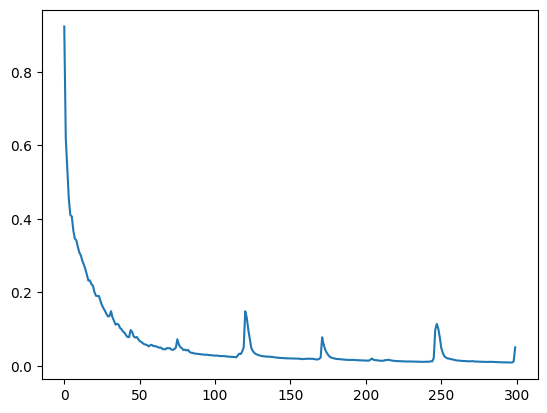

In [ ]:
plt.plot(range(epoch),history['loss'],label="loss")

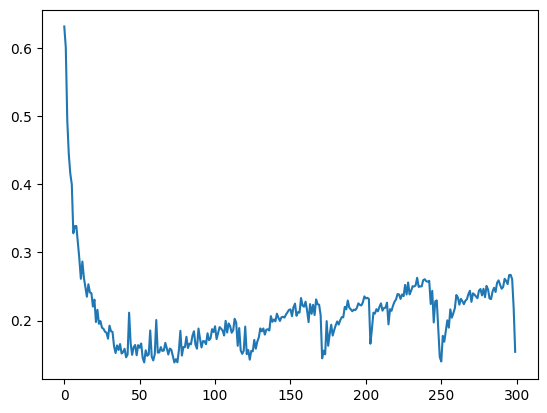

In [ ]:
plt.plot(range(epoch),history['val_loss'],label="val_loss")

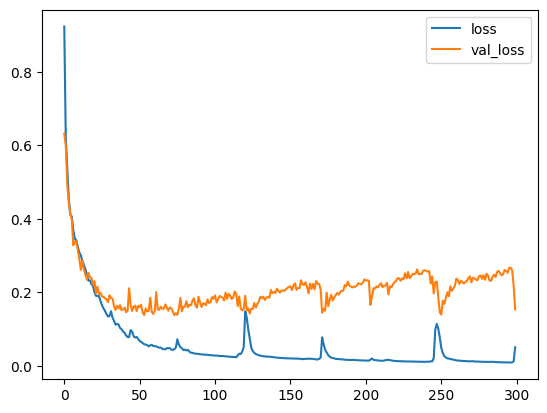

In [ ]:
plt.plot(range(epoch),history['loss'],label="loss")
plt.plot(range(epoch),history['val_loss'],label="val_loss")
plt.legend()

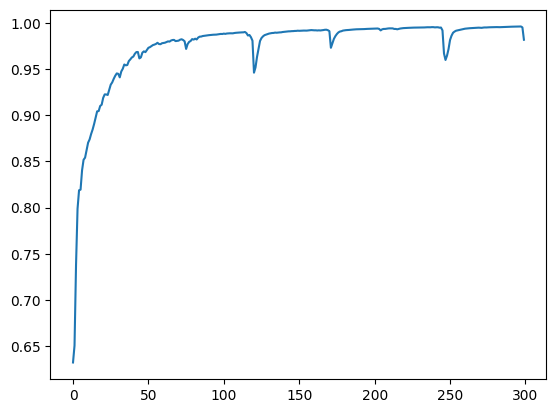

In [ ]:
plt.plot(range(epoch),history['accuracy'],label="accuracy")

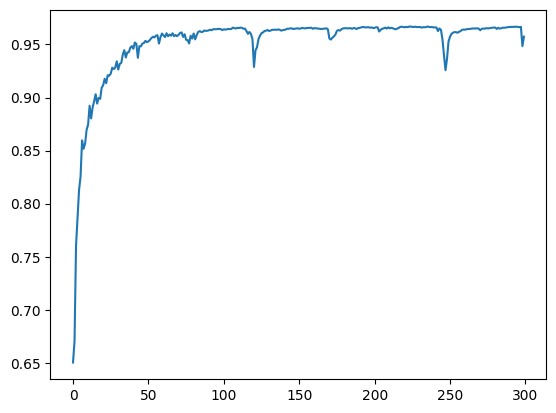

In [ ]:
plt.plot(range(epoch),history['val_accuracy'],label="val_accuracy")

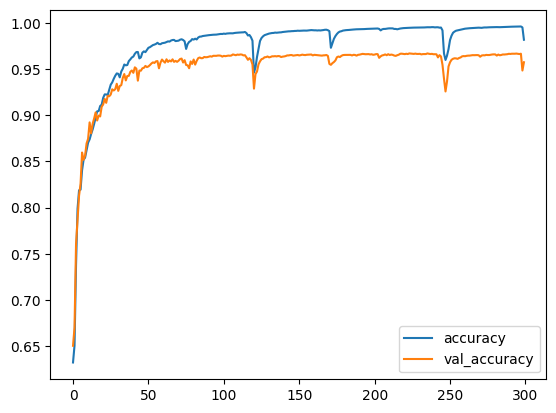

In [ ]:
plt.plot(range(epoch),history['accuracy'],label="accuracy")
plt.plot(range(epoch),history['val_accuracy'],label="val_accuracy")
plt.legend()

## Testing model with test data

In [ ]:
testx=cv.resize(cv.cvtColor(cv.imread("/content/drive/MyDrive/Imagematting/dataset/images/170.png"),cv.COLOR_BGR2RGB),(128,128))
testy=cv.resize(cv.imread("/content/drive/MyDrive/Imagematting/dataset/masks/170.png",cv.IMREAD_GRAYSCALE),(128,128))
testy=(testy>0).astype(np.uint8)

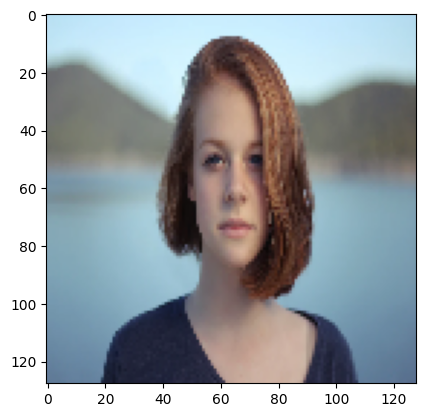

In [ ]:
plt.imshow(testx)

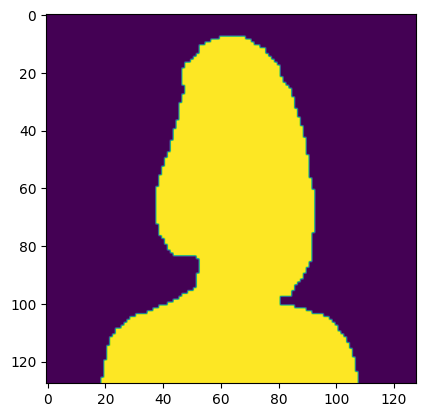

In [ ]:
plt.imshow(testy)

### Predictiing data

In [ ]:
#Expanding dimensions to fit the data for the model
test_prediction=model.predict(np.expand_dims(testx,axis=0))[0]

1/1 [==============================] - 1s 970ms/step


In [ ]:
test_prediction=np.argmax(test_prediction,axis=-1)

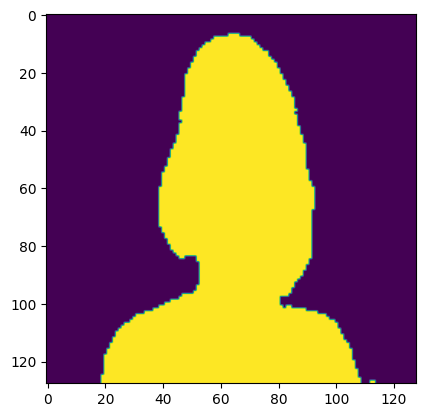

In [ ]:
plt.imshow(test_prediction)

In [ ]:
dice_score1=dice_score(testy,test_prediction)

In [ ]:
print("Dice score for first prediction: ",dice_score1)

Dice score for first prediction:  [0.9925654633308166, 0.9872242419757556, 2.0]


### Seperating it into region

In [ ]:
region=testx.copy()

In [ ]:
boolregion=test_prediction.astype(bool)

In [ ]:
region[~boolregion]=0

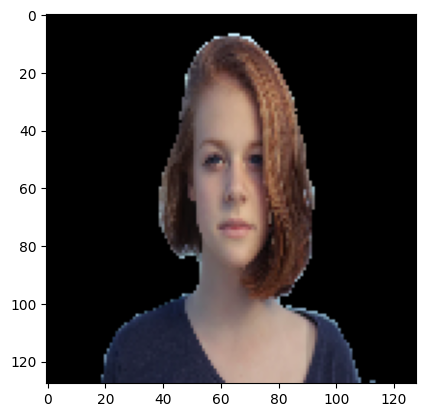

In [ ]:
plt.imshow(region)

### Passing new image to the model

In [ ]:
img=cv.cvtColor(cv.imread("/content/drive/MyDrive/Imagematting/newdata/IMG.webp"),cv.COLOR_BGR2RGB)

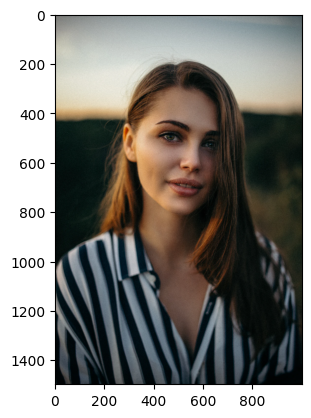

In [ ]:
plt.imshow(img)

In [ ]:
original_shape=img.shape

In [ ]:
original_shape

(1498, 1000, 3)

In [ ]:
img=cv.resize(img,(128,128))

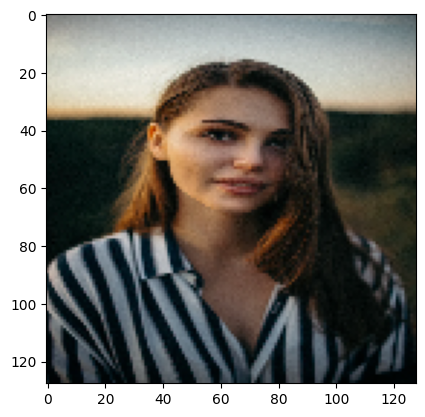

In [ ]:
plt.imshow(img)

In [ ]:
prediction=model.predict(np.expand_dims(img,axis=0))[0]

1/1 [==============================] - 0s 28ms/step


In [ ]:
prediction=np.argmax(prediction,axis=-1)

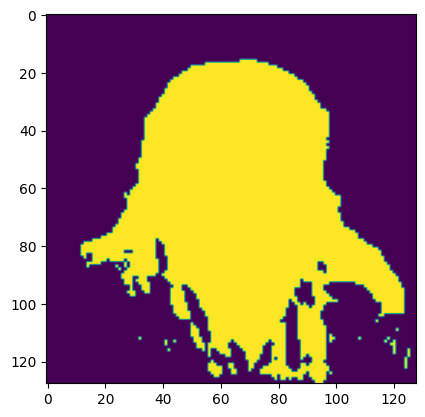

In [ ]:
plt.imshow(prediction)

### Fetching the segmented region from original image

In [ ]:
region_new=img.copy()

In [ ]:
#Converting the grayscale segmented image into boolean value
region_bool=prediction.astype(bool)

In [ ]:
#Converting background transperent
region_new[~region_bool]=0

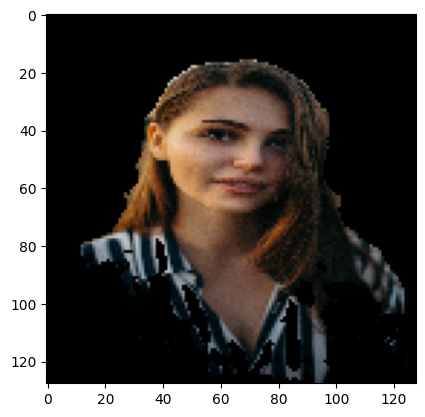

In [ ]:
plt.imshow(region_new)

In [ ]:
region_new=cv.resize(region_new,(original_shape[1],original_shape[0]))

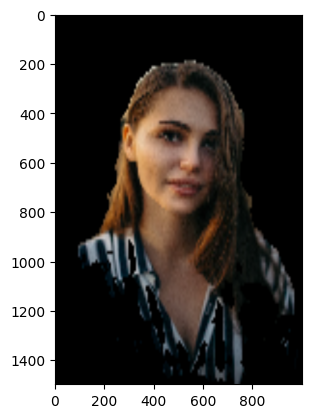

In [ ]:
plt.imshow(region_new)

In [ ]:
region_new=cv.cvtColor(region_new,cv.COLOR_RGB2BGR)

### Saving image to device

In [ ]:
cv.imwrite("/content/drive/MyDrive/Imagematting/newdata/IMGSegmented.JPG",region_new)

True

### Saving model

In [ ]:
model.save("/content/drive/MyDrive/Imagematting/imagematting.keras")